# Data Collection


Data Science - CA#00: *Etherscan* - Spring 1403 \
In this section, we will use web scraping to gather transaction data from the Ethereum blockchain using the Etherscan block explorer.

To accomplish this task, we will employ web scraping techniques to extract the transaction data from the Etherscan website. The URL we will be targeting for our data collection is:

[https://etherscan.io/txs](https://etherscan.io/txs)

### Steps

1. **Navigate to the URL**: Use Selenium to open the Etherscan transactions page in a browser.

2. **Locate the Transaction Data**: Identify the HTML elements that contain the transaction data for the specified block range.

3. **Extract the Data**: Write a script to extract the transaction details e.g. Hash, Method, Block, etc.

4. **Handle Pagination**: If the transactions span multiple pages, implement pagination handling to navigate through the pages and collect all relevant transaction data.

5. **Store the Data**: Save the extracted transaction data into a structured format, such as a CSV file or a pandas DataFrame, for further analysis.

### Considerations

- **Rate Limiting**: Be mindful of the website's rate limits to avoid being blocked. Implement delays between requests if necessary.
- **Dynamic Content**: The Etherscan website may load content dynamically. Ensure that Selenium waits for the necessary elements to load before attempting to scrape the data.
- **Data Cleaning**: After extraction, clean the data to remove any inconsistencies or errors that may have occurred during the scraping process.

### Resources

- [Beautiful Soup Documentation](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)
- [Selenium Documentation](https://selenium-python.readthedocs.io/)
- [Pandas Documentation](https://pandas.pydata.org/docs/)
- [Ethereum](https://ethereum.org/en/)

In [14]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import sys
import time
import pandas as pd

In [15]:
def updateDFs(dfs, transaction):
    df = pd.DataFrame(columns=['Txn Hash', 'Method', 'Block', 'Age', 'From', 'To', 'Value', 'Txn Fee'])
    df = df.dropna(how='all')
    df = df.dropna(axis=1, how='all')
    df = pd.concat([df, pd.DataFrame([transaction])], ignore_index=True)
    dfs.append(df)
    return dfs

# Navigate to the URL
driver = webdriver.Chrome()
driver.get('https://etherscan.io/txs')

wait = WebDriverWait(driver, sys.maxsize)

dfs = []
prev_block = -1

while True:
    # Dynamic Content
    wait.until(EC.presence_of_element_located((By.TAG_NAME, 'tbody')))
    
    # Locate the Transaction Data
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    rows = soup.find_all('tr')
    end = False

    for row in rows[1:]:
        cols = row.find_all('td')
        
        # Extract the Data
        transaction = {
            # Data Cleaning
            'Txn Hash': cols[1].text.strip(),
            'Method': cols[2].text.strip(),
            'Block': int(cols[3].text.strip()),
            'Age': cols[5].text.strip(),
            'From': cols[7].text.strip(),
            'To': cols[9].text.strip(),
            'Value': float(''.join([c for c in cols[10].text.strip() if c.isdigit() or c == '.'])), 
            'Txn Fee':cols[11].text.strip()
        }

        flag = False
        for idx, df in enumerate(dfs):
            if df['Block'].iloc[0] == transaction['Block']:
                new_df = pd.concat([df, pd.DataFrame([transaction])], ignore_index=True)
                dfs[idx] = new_df
                flag = True
                break
        if flag == False:
            if len(dfs) < 10:
                if prev_block == -1 or abs(prev_block - transaction['Block']) == 1 or (abs(prev_block - transaction['Block']) == 2 and len(dfs) < 9):
                    dfs = updateDFs(dfs, transaction)

                elif abs(prev_block - transaction['Block']) > 2:
                    dfs.clear()
                    dfs = updateDFs(dfs, transaction)

                prev_block = transaction['Block']

            elif len(dfs) == 10 and abs(prev_block - transaction['Block']) >= 5:
                end = True
                break

    if end == True: break

    next_button = soup.find('a', {'aria-label': 'Next'})
    if next_button:
        
        # Handle Pagination
        button = driver.find_element(By.CSS_SELECTOR, "a[aria-label='Next']")
        driver.execute_script('arguments[0].click();', button)

        # Rate Limiting
        time.sleep(2)
    else:
        break 

dfs = sorted(dfs, key=lambda df: df['Block'].iloc[0])
dfs = pd.concat(dfs)

# Store the Data
dfs.to_csv('transactions.csv', index=False)
driver.quit()

## Data Analysis

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
FILE_PATH = 'transactions.csv'

### Load Data

In [18]:
df = pd.read_csv(FILE_PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3573 entries, 0 to 3572
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Txn Hash  3573 non-null   object 
 1   Method    3573 non-null   object 
 2   Block     3573 non-null   int64  
 3   Age       3573 non-null   object 
 4   From      3573 non-null   object 
 5   To        3573 non-null   object 
 6   Value     3573 non-null   float64
 7   Txn Fee   3573 non-null   float64
dtypes: float64(2), int64(1), object(5)
memory usage: 223.4+ KB


In [19]:
df.describe()

,Block,Value,Txn Fee
count,3.573000e+03,3573.000000,3573.000000
mean,1.937878e+07,14.236817,0.013202
std,2.643435e+00,546.468764,0.021732
min,1.937878e+07,0.000000,0.002682
25%,1.937878e+07,0.000000,0.002904
50%,1.937878e+07,0.000000,0.006441
75%,1.937878e+07,0.100000,0.020349
max,1.937878e+07,23071.167231,0.371687


### Data Cleaning

In [20]:
df['Txn Fee'] = pd.to_numeric(df['Txn Fee'], errors='coerce')
df['Value'] = pd.to_numeric(df['Value'], errors='coerce')

In [21]:
duplicate_rows = df[df.duplicated()]
df = df.drop_duplicates()

In [22]:
df = df[(df != 0).all(axis=1)]
df = df[df['From'].astype(str) != df['To'].astype(str)]
df['Age'] = pd.to_numeric(df['Age'].str.extract('(\d+)')[0], errors='coerce')

<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
C:\Users\asus\AppData\Local\Temp\ipykernel_19844\3736863615.py:3: SyntaxWarning: invalid escape sequence '\d'
  df['Age'] = pd.to_numeric(df['Age'].str.extract('(\d+)')[0], errors='coerce')


In [23]:
df = df.drop(['To'], axis=1)
df = df.drop(['From'], axis=1)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1131 entries, 0 to 3572
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Txn Hash  1131 non-null   object 
 1   Method    1131 non-null   object 
 2   Block     1131 non-null   int64  
 3   Age       1131 non-null   int64  
 4   Value     1131 non-null   float64
 5   Txn Fee   1131 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 61.9+ KB


### Statistical Analysis

In [25]:
mean_txn_fee = df['Txn Fee'].mean()
std_dev_txn_fee = df['Txn Fee'].std()

mean_value = df['Value'].mean()
std_dev_value = df['Value'].std()

print(f"Mean Transaction Fee: {mean_txn_fee}")
print(f"Standard Deviation of Transaction Fee: {std_dev_txn_fee}")
print(f"Mean Value: {mean_value}")
print(f"Standard Deviation of Value: {std_dev_value}")

Mean Transaction Fee: 0.011045865419982316
Standard Deviation of Transaction Fee: 0.025149878082308227
Mean Value: 43.032038159950474
Standard Deviation of Value: 970.3079943441229


### Visualization

In [26]:
sns.set(style="whitegrid")

##### Histogram:

- **Definition:** A histogram is a graphical representation of the distribution of a dataset. It consists of bars representing the frequencies or relative frequencies of different intervals (bins) of the data.

- **Purpose:** It provides a visual representation of the underlying probability distribution of continuous numerical data.

- **Key Points:**
  - Bar heights represent the frequency or relative frequency of data within each bin.
  - Suitable for understanding the shape, center, and spread of a distribution.


Text(0.5, 1.0, 'Histogram of Transaction Fee')

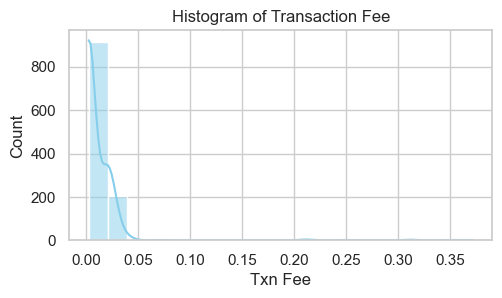

In [27]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
sns.histplot(df['Txn Fee'], bins=20, kde=True, color='skyblue')
plt.title('Histogram of Transaction Fee')

Text(0.5, 1.0, 'Histogram of Value')

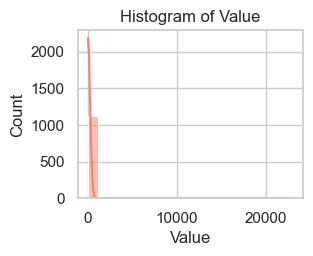

In [28]:
plt.subplot(2, 2, 2)
sns.histplot(df['Value'], bins=20, kde=True, color='salmon')
plt.title('Histogram of Value')

##### Normal Distribution Plot:

- **Representation:** A curve that is symmetric and bell-shaped, representing a normal distribution.

- **Purpose:** Visualize how data is distributed assuming a normal distribution.

- **Key Points:**
  - Bell-shaped curve with a peak at the mean.
  - Symmetric around the mean.
  - Controlled by mean and standard deviation parameters.

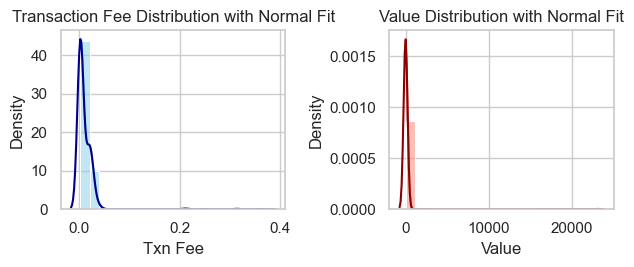

In [29]:
plt.subplot(2, 2, 3)
sns.histplot(df['Txn Fee'], bins=20, kde=True, color='skyblue', stat='density')
sns.kdeplot(df['Txn Fee'], color='darkblue')
plt.title('Transaction Fee Distribution with Normal Fit')

plt.subplot(2, 2, 4)
sns.histplot(df['Value'], bins=20, kde=True, color='salmon', stat='density')
sns.kdeplot(df['Value'], color='darkred')
plt.title('Value Distribution with Normal Fit')

plt.tight_layout()
plt.show()

The values ​​are well fitted to the normal distribution. And they are distributed in a much more concentrated way around the mean. which is consistent with our expectation of human performance.

#### Box Plot (Box-and-Whisker Plot):

- **Representation:** A standardized way of displaying the distribution based on a five-number summary.

- **Purpose:** Provide a summary of central tendency and spread, highlighting potential outliers.

- **Key Points:**
  - Box represents interquartile range (IQR) between Q1 and Q3.
  - Line inside the box is the median, and "whiskers" extend to minimum and maximum values within a certain range.
  - Outliers may be plotted individually.


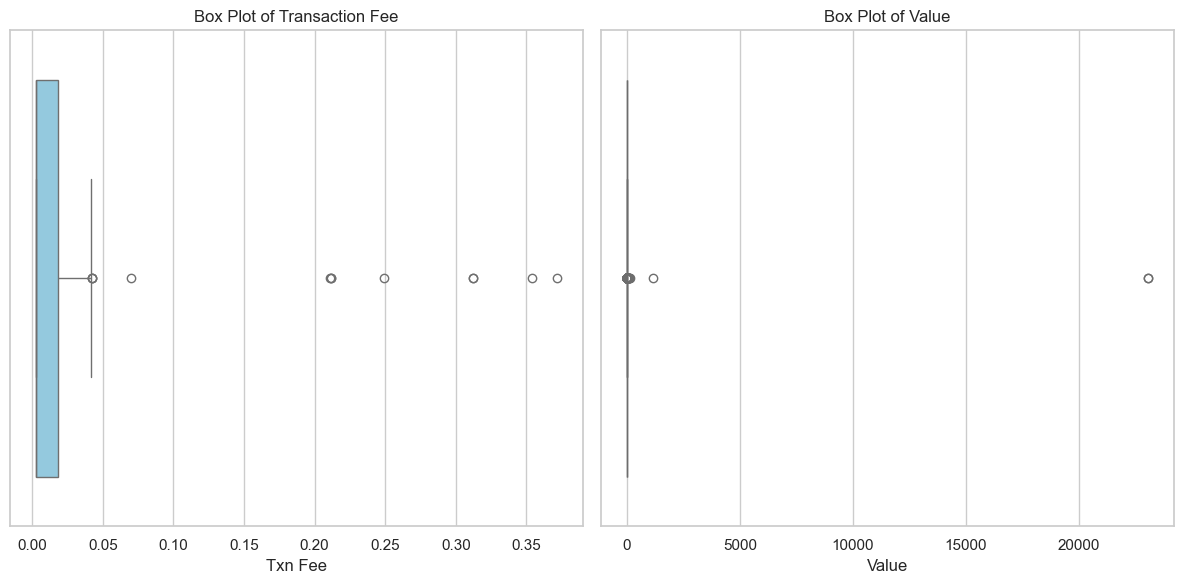

In [30]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x=df['Txn Fee'], color='skyblue')
plt.title('Box Plot of Transaction Fee')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['Value'], color='salmon')
plt.title('Box Plot of Value')

plt.tight_layout()
plt.show()

#### Violin Plot:

- **Representation:** A combination of a box plot and a kernel density plot.

- **Purpose:** Display the distribution of data across different levels or categories.

- **Key Points:**
  - Width of the plot represents the density of the data at different values.
  - Box plot inside indicates quartiles and median.
  - Useful for visualizing both summary statistics and distribution shape.


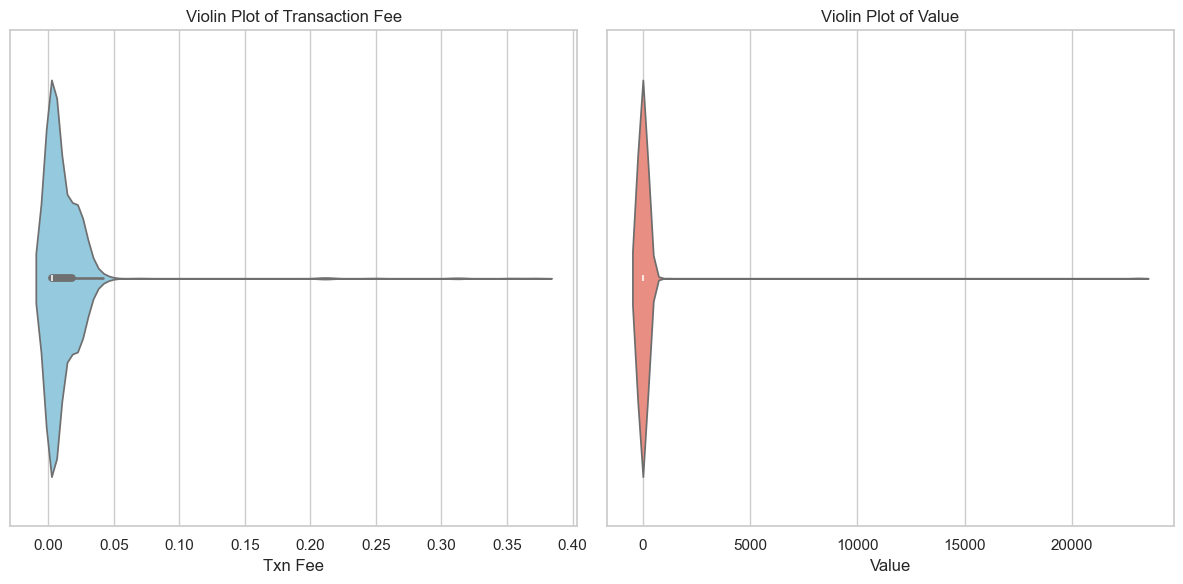

In [31]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.violinplot(x=df['Txn Fee'], color='skyblue')
plt.title('Violin Plot of Transaction Fee')

plt.subplot(1, 2, 2)
sns.violinplot(x=df['Value'], color='salmon')
plt.title('Violin Plot of Value')

plt.tight_layout()
plt.show()

## Data Sampling and Analysis

In [32]:
IRRELEVANT_COLUMNS = {"From", "To"}
TO_NUMERIC_COLUMNS = {"Txn Fee", "Value"}
SAMPLE_SIZE = int(0.05 * len(df)) #0.05 * total_population

### Load Data

In [33]:
df = pd.read_csv(FILE_PATH)

### Data Cleaning

In [34]:
def get_missing_values(df: pd.DataFrame):
    total_entities = len(df)
    missing_values = df.isna().sum()
    missing_proportion = (missing_values / total_entities) * 100
    return pd.DataFrame({'feature':missing_values.index, 'Count':missing_values.values, 'Percent':missing_proportion.values})

lost_values = get_missing_values(df)
lost_values

,feature,Count,Percent
0,Txn Hash,0,0.0
1,Method,0,0.0
2,Block,0,0.0
3,Age,0,0.0
4,From,0,0.0
5,To,0,0.0
6,Value,0,0.0
7,Txn Fee,0,0.0


there is no missing value in this special case.

In [35]:

def handle_missing_data(_df: pd.DataFrame, loss_values_stats: pd.DataFrame, del_threshold: float = 0.5):
    mean_kind = ['i', 'f']
    mode_kind = ['O']
    df = _df.copy(deep=True)
    for feature, percent in zip(loss_values_stats['feature'], loss_values_stats['Percent']):
        if percent == 0 :
            continue
        elif percent >= del_threshold * 100:
            df.drop(feature, axis=1, inplace=True)
        elif df[feature].dtype.kind in mean_kind:
            df[feature].fillna(df[feature].mean(), inplace=True)
        elif df[feature].dtype.kind in mode_kind:
            df[feature].fillna(df[feature].mode()[0], inplace=True)
    return df

def handel_duplicated_values(df: pd.DataFrame):
    df = df.drop_duplicates()
    return df

def drop_irrelevant_columns(df: pd.DataFrame, irrelevant_columns):
    for c in irrelevant_columns:
        df = df.drop([c], axis=1)
    return df

def replace_with_numeric(df: pd.DataFrame, columns):
    for c in columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    for c in columns:
        mean_value = df[c].mean(skipna=True)
        df[c] = pd.to_numeric(df[c], errors='coerce').fillna(mean_value)
    return df

def special_data_conversion(df):
    df = df[(df != 0).all(axis=1)]
    df = df[df['From'].astype(str) != df['To'].astype(str)]
    df['Age'] = pd.to_numeric(df['Age'].str.extract('(\d+)')[0], errors='coerce')
    return df

def cleaning_data(df: pd.DataFrame, irrelevant_columns, lost_values, to_numeric_columns):
    fixed = replace_with_numeric(df, to_numeric_columns)
    fixed = handle_missing_data(fixed, lost_values)
    fixed = special_data_conversion(fixed)
    fixed = handel_duplicated_values(fixed)
    fixed = drop_irrelevant_columns(fixed, irrelevant_columns)
    return fixed


<>:36: SyntaxWarning: invalid escape sequence '\d'
<>:36: SyntaxWarning: invalid escape sequence '\d'
C:\Users\asus\AppData\Local\Temp\ipykernel_19844\3731271665.py:36: SyntaxWarning: invalid escape sequence '\d'
  df['Age'] = pd.to_numeric(df['Age'].str.extract('(\d+)')[0], errors='coerce')


In [36]:
df = cleaning_data(df, IRRELEVANT_COLUMNS, lost_values, TO_NUMERIC_COLUMNS)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1131 entries, 0 to 3572
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Txn Hash  1131 non-null   object 
 1   Method    1131 non-null   object 
 2   Block     1131 non-null   int64  
 3   Age       1131 non-null   int64  
 4   Value     1131 non-null   float64
 5   Txn Fee   1131 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 61.9+ KB


## Sampling Methods

#### Simple Random Sampling (SRS):
- **Functionality:** Involves randomly selecting individuals from the population with an equal probability of being chosen. Every individual has an equal chance of being part of the sample.
- **Use Case:** Suitable when the population is homogeneous and no specific characteristics need to be considered in the sampling process.

#### Stratified Sampling:
- **Functionality:** Divides the population into subgroups (strata) based on certain characteristics. Samples are then independently taken from each stratum. This ensures representation from different subgroups.
- **Use Case:** Useful when the population has distinct subgroups with varying characteristics, and you want to ensure each subgroup is adequately represented in the sample.

#### Systematic Sampling:
- **Functionality:** Involves selecting every kth individual from the population after randomly selecting a starting point. The value of k is determined by dividing the population size by the desired sample size.
- **Use Case:** Useful when the population is ordered in some way, and a systematic approach simplifies the sampling process.

#### Cluster Sampling:
- **Functionality:** Divides the population into clusters, randomly selects some clusters, and then includes all individuals within the selected clusters in the sample.
- **Use Case:** Appropriate when the population is naturally divided into clusters, and it is more practical to sample entire clusters rather than individual elements.

#### Convenience Sampling:
- **Functionality:** Involves selecting individuals who are easiest to reach or readily available. This method is often used for its convenience but may introduce bias.
- **Use Case:** Suitable for preliminary research or when access to the entire population is challenging.

#### Quota Sampling:
- **Functionality:** Similar to stratified sampling, but the researcher sets quotas for each stratum based on certain characteristics. Individuals are then conveniently selected to meet these quotas.
- **Use Case:** Useful when specific proportions of the population need to be represented in the sample, but random selection within strata is not feasible.


If your primary goal is to obtain a broad, representative sample of Etherscan transactions ``without a specific focus`` on distinct subgroups or patterns, `Simple Random Sampling` (SRS) might be a suitable choice. \
If there are ``identifiable subgroups`` in the data that you believe are crucial for analysis, and you want to ensure representation from each subgroup, `Stratified Sampling` could be more appropriate.

### SRS

In [37]:
srs_sample = df.sample(SAMPLE_SIZE, random_state=42)
srs_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56 entries, 2906 to 197
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Txn Hash  56 non-null     object 
 1   Method    56 non-null     object 
 2   Block     56 non-null     int64  
 3   Age       56 non-null     int64  
 4   Value     56 non-null     float64
 5   Txn Fee   56 non-null     float64
dtypes: float64(2), int64(2), object(2)
memory usage: 3.1+ KB


#### SRS Sampling Size:
Determining an appropriate sample size depends on several factors, including the size of the population, the desired level of precision, and the available resources for the study. However, a common rule of thumb is that a sample size of around 5% of the population can often provide reliable results for a wide range of scenarios.

### Stratified Sampling

In [38]:
groups = df.groupby('Block')
stratified_sample = groups.apply(lambda x: x.sample(n=round(len(x) * SAMPLE_SIZE / len(df)), random_state=42))
stratified_sample.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 56 entries, (19378776, 203) to (19378785, 3455)
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Txn Hash  56 non-null     object 
 1   Method    56 non-null     object 
 2   Block     56 non-null     int64  
 3   Age       56 non-null     int64  
 4   Value     56 non-null     float64
 5   Txn Fee   56 non-null     float64
dtypes: float64(2), int64(2), object(2)
memory usage: 5.7+ KB


C:\Users\asus\AppData\Local\Temp\ipykernel_19844\4097226935.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = groups.apply(lambda x: x.sample(n=round(len(x) * SAMPLE_SIZE / len(df)), random_state=42))


### Statistical Analysis

If there is less difference, the sampling is more precise

In [39]:
srs_mean = srs_sample['Value'].mean()
srs_std = srs_sample['Value'].std()
stratified_mean = stratified_sample['Value'].mean()
stratified_std = stratified_sample['Value'].std()
population_mean = df['Value'].mean()
population_std = df['Value'].std()

print(f"SRS Mean: {srs_mean}")
print(f"SRS Standard Deviation: {srs_std}")
print(f"Stratified Sample Mean: {stratified_mean}")
print(f"Stratified Sample Standard Deviation: {stratified_std}")
print(f"Population Mean: {population_mean}")
print(f"Population Standard Deviation: {population_std}")
print("------------------------------------------------------------------------------")

mean_diff_srs = abs(srs_mean - population_mean)
mean_diff_stratified = abs(stratified_mean - population_mean)
print(f"Difference in Mean (SRS vs Population): {mean_diff_srs}")
print(f"Difference in Mean (Stratified vs Population): {mean_diff_stratified}")

std_diff_srs = abs(srs_std - population_std)
std_diff_stratified = abs(stratified_std - population_std)
print(f"Difference in Standard Deviation (SRS vs Population): {std_diff_srs}")
print(f"Difference in Standard Deviation (Stratified vs Population): {std_diff_stratified}")

SRS Mean: 1.2575599578035714
SRS Standard Deviation: 6.661095032547252
Stratified Sample Mean: 0.6851191585892857
Stratified Sample Standard Deviation: 1.5251736951504393
Population Mean: 43.032038159950474
Population Standard Deviation: 970.3079943441229
------------------------------------------------------------------------------
Difference in Mean (SRS vs Population): 41.7744782021469
Difference in Mean (Stratified vs Population): 42.34691900136119
Difference in Standard Deviation (SRS vs Population): 963.6468993115757
Difference in Standard Deviation (Stratified vs Population): 968.7828206489725


### Visualization

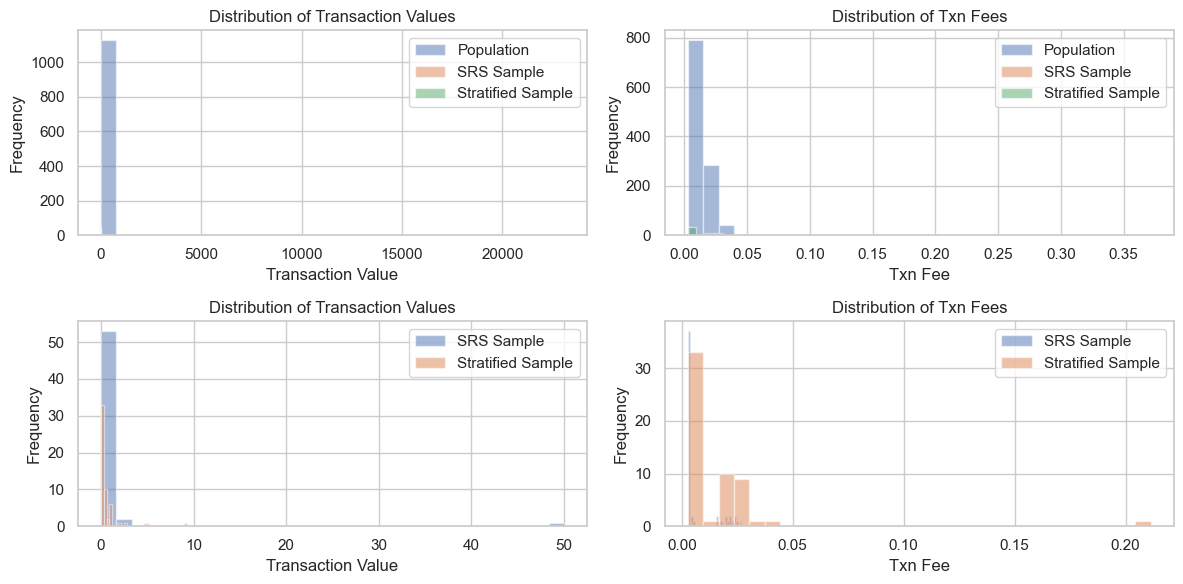

In [44]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.hist(df['Value'], bins=30, alpha=0.5, label='Population')
plt.hist(srs_sample['Value'], bins=30, alpha=0.5, label='SRS Sample')
plt.hist(stratified_sample['Value'], bins=30, alpha=0.5, label='Stratified Sample')
plt.title('Distribution of Transaction Values')
plt.xlabel('Transaction Value')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(2, 2, 2)
plt.hist(df['Txn Fee'], bins=30, alpha=0.5, label='Population')
plt.hist(srs_sample['Txn Fee'], bins=30, alpha=0.5, label='SRS Sample')
plt.hist(stratified_sample['Txn Fee'], bins=30, alpha=0.5, label='Stratified Sample')
plt.title('Distribution of Txn Fees')
plt.xlabel('Txn Fee')
plt.ylabel('Frequency')
plt.legend()


plt.subplot(2, 2, 3)
plt.hist(srs_sample['Value'], bins=30, alpha=0.5, label='SRS Sample')
plt.hist(stratified_sample['Value'], bins=30, alpha=0.5, label='Stratified Sample')
plt.title('Distribution of Transaction Values')
plt.xlabel('Transaction Value')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(2, 2, 4)
plt.hist(srs_sample['Txn Fee'], bins=30, alpha=0.5, label='SRS Sample')
plt.hist(stratified_sample['Txn Fee'], bins=30, alpha=0.5, label='Stratified Sample')
plt.title('Distribution of Txn Fees')
plt.xlabel('Txn Fee')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

## Questions

### 1. What are some potential limitations when using web scraping for data collection? Specifically, what problems did you face while fetching data from Etherscan? What problems can these limitations cause in your analysis?

Web scraping is a powerful tool for data collection, but it does come with several limitations:

- **Website Structure Changes:** Websites frequently update their structures, which can break your web scraping scripts.
- **Complex Websites:** Handling complex websites with dynamic content can be challenging.
- **Large Scale Extraction:** Extracting data on a large scale can be difficult and may lead to your IP getting banned by the target website.
- **Data Quality and Relevance:** The data collected through web scraping might not always be accurate or relevant.

### 2. What can make your analysis untrustworthy? What are your solutions?

##### Incomplete Data:
- **Strategy:** Implement error handling in the scraping process to identify and address missed data points.
- **Objective:** Ensure a robust data collection process that captures all relevant information.

##### Data Quality Issues:
- **Strategy:** Perform thorough data cleaning procedures.
- **Approach:**
  - Handle missing values appropriately.
  - Validate the consistency of the data.
- **Objective:** Enhance the overall quality and reliability of the collected data.


### 3. How did the visualization help you in understanding the data? What could you interpret from the plots?

Visualizations provide a clear and intuitive representation of data patterns and distributions.
##### Interpretation of Plots:

##### Histograms:
- **Purpose:** Show the distribution of transaction values.

##### Normal Distribution Plots:
- **Purpose:** Compare the empirical distribution with a theoretical normal distribution.

##### Box Plots and Violin Plots:
- **Purpose:** Identify outliers and visualize data distribution.


### 4. How do the two sampling methods differ in their output? Compare these and explain which one is a better fit to the population.

Simple Random Sampling (SRS) and Stratified Sampling are both statistical measurement tools used to obtain a sample from a population.

- **SRS** is a method where every member of the population has an equal chance of being selected. It’s often used when there is very little information available about the population, or when the population is homogeneous.
- **Stratified Sampling**, on the other hand, first divides the population into smaller groups, or strata, based on shared characteristics. Then, samples are taken from each group. This method is beneficial when the population is heterogeneous.

The choice between SRS and Stratified Sampling depends on the nature of the population. If the population is homogeneous, SRS could be a better fit. However, if there are clear subgroups in the population that you want to represent in your sample, Stratified Sampling would be more appropriate.